XS plotting
===========

This notebook uses the ``pyne.ace`` module to plot cross-sections.
ACE (A Compact ENDF) files are a point-wise representation of cross-section,
considered to be "continuous energy" (as in not discrete) for all practical
purposes.

ACE files originate from processing ENDFs (Evaluated Nuclear Data File) with
some cross section preparation code, such as NJOY.
ACE files already contain some form of approximation compared to ENDFs
(at least some form of doppler broadening, since ACE libraries are for a certain
temperature, and most likely assumptions regarding unresolved resonances and
how to represent them as points, but I would have to check more precisely to
make a strong statement), so in the future I would like to change this to using
ENDF for the plotting and making these assumptions explicit here.

In [458]:
%matplotlib inline

latex = False

if latex:
    import matplotlib as mpl
    mpl.use("pgf")
    pgf_with_rc_fonts = {
        "font.family": "serif",
        "font.serif": [],                   # use latex default serif font
        "font.sans-serif": ["DejaVu Sans"], # use a specific sans-serif font
    }
    mpl.rcParams.update(pgf_with_rc_fonts)

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pyne
from pyne import ace
from pyne.data import atomic_mass

mpl.style.use('seaborn')

#if not os.path.isfile("/Users/rodrigo/opt/Serpent2/xsdata/XSdata_jeff311/acedata/54135JEF311.ace"):
#    from urllib import urlretrieve
#    urlretrieve("https://www-nds.iaea.org/wolfram/w180/beta3/W180.ace", "W180.ace")

n_mass = 1.00866491588
Nav = 6.02E23

ene = 'Neutron energy (MeV)'

xs = '$ \sigma $ (barn)'
xs_t = '$ \sigma_{\mathrm{t}} $ (barn)'
xs_e = '$ \sigma_{\mathrm{e}} $ (barn)'
xs_a = '$ \sigma_{\mathrm{a}} $ (barn)'
xs_f = '$ \sigma_{\mathrm{f}} $ (barn)'
xs_gamma = '$ \sigma_{\gamma} $ (barn)'
xs_alpha = '$ \sigma_{\\alpha} $ (barn)'

nut = '$ \\nu_{\mathrm{t}}$'
eta = '$ \eta $ '

ace_path = "/Users/rodrigo/opt/Serpent2/xsdata/jeff311/acedata/"
ace_end = "JEF311.ace"


def load_ace(nuclide, suffix=ace_end):
    """
    The main class in ``pyne.ace`` is called ``Library``.
    It is instantiated using the name of an ACE file.
    Here we use the files distributed with Serpent.
    """
    lib = ace.Library(ace_path + str(nuclide) + suffix)
    lib.read()
    return lib


def co_alpha(mass):
    return ((mass - n_mass)/(mass + n_mass))**2


def min_collisions(mass, initial_energy=2, final_energy=2.5E-8):
    alpha = co_alpha(mass)
    return np.log(final_energy/initial_energy) / np.log(alpha)


def ln_energy_decrement(mass):
    alpha = co_alpha(mass)
    return 1 + (alpha/(1 - alpha))*np.log(alpha)


def ave_collisions(mass, initial_energy=2, final_energy=2.5E-8):
    xi = ln_energy_decrement(mass)
    return (1/xi) * np.log(initial_energy/final_energy)


def moderating_power(mass, nuclide):
    xi = ln_energy_decrement(mass)
    xse = nuclide.reactions[2].sigma
    return xi * xse


def moderating_ratio(mass, nuclide):
    mod_pow = moderating_power(mass, nuclide)
    xsa = nuclide.reactions[102].sigma
    return mod_pow / xsa


def nu_unionized(nuclide):
    nuclide_nu = np.interp(nuclide.energy, nuclide.nu_t_energy, nuclide.nu_t_value)
    return nuclide_nu


def eta_micro(nuclide):
    nuclide_fission = nuclide.reactions[18].sigma
    nuclide_capture = nuclide.reactions[102].sigma
    nuclide_sigma_a = nuclide_fission + nuclide_capture

    nuclide_FAR = nuclide_fission / nuclide_sigma_a
    nuclide_nu = np.interp(nuclide.energy, nuclide.nu_t_energy, nuclide.nu_t_value)
    nuclide_eta = nuclide_nu * nuclide_FAR
    return nuclide_eta


def save_plot(save):
    if save:
        plt.savefig(f'{save}.pdf', bbox_inches='tight')


def plot_xs(energy, xs, xs_label, lw=0.5, title=None, save=None, ymin=None):
    fig, ax = plt.subplots()
    ax.loglog(energy, xs,linewidth=lw)
    ax.set(xlabel=ene,ylabel=xs_label,title=title)
    ax.set_ylim(ymin=ymin)
    save_plot(save)
    return fig, ax


def plot_semi(energy, semi, semi_label, lw, title):
    fig, ax = plt.subplots()
    ax.semilogx(energy, semi,linewidth=lw)
    ax.set(xlabel=ene,ylabel=semi_label,title=title)
    return fig, ax


def plot_nueta(energy, nueta, ne_label, lw=0.5, title=None, save=None, ymin=None):
    fig, ax = plot_semi(energy, nueta, ne_label, lw, title)
    save_plot(save)
    return fig, ax


def plot_eta(nuclide, lw=0.5, title=None, save=None):
    nuclide_fission = nuclide.reactions[18].sigma
    nuclide_capture = nuclide.reactions[102].sigma
    nuclide_sigma_a = nuclide_fission + nuclide_capture

    nuclide_FAR = nuclide_fission / nuclide_sigma_a
    nuclide_nu = np.interp(nuclide.energy, nuclide.nu_t_energy, nuclide.nu_t_value)
    nuclide_eta = nuclide_nu * nuclide_FAR

    fig, ax = plot_nueta(nuclide.energy, nuclide_eta, eta,
                         lw=lw, title=title)
    save_plot(save)
    return fig, ax


def plot_ratio(energy, ratio, ratio_label, lw=0.5, title=None, save=None, ylim=(-0.05, 1.05)):
    fig, ax = plot_semi(energy, ratio, ratio_label, lw, title)
    ax.set_ylim(ylim)
    save_plot(save)
    return fig, ax


def plot_temperatures(lib, mt, mt_label, lw=0.5, title=None, save=None):
    entries = sorted(lib.tables.keys())
    temperatures = [300, 600, 900, 1200, 1500, 1800]
    fig, ax = plt.subplots()
    for entry, temperature in zip(entries, temperatures):
        if mt == 1:
            __xs = lib.tables[entry].sigma_t
        else:
            __xs = lib.tables[entry].reactions[mt].sigma
        ax.loglog(lib.tables[entry].energy, __xs,
                  # label=f'{temperature: >4d} K',
                  label=f'{temperature} K',
                  linewidth=lw)
    ax.legend()
    ax.set(xlabel=ene,ylabel=mt_label,title=title)
    save_plot(save)
    return fig, ax


def plot_compare_nuclides(nuclides, name_labels, mt, mt_label, lw=0.5, title=None, save=None):
    fig, ax = plt.subplots()
    for nuclide, label in zip(nuclides, name_labels):
        if mt == 1:
            __xs = nuclide.sigma_t
        else:
            __xs = nuclide.reactions[mt].sigma
        ax.loglog(nuclide.energy, __xs,
                  label=label,
                  linewidth=lw)
    ax.legend()
    ax.set(xlabel=ene,ylabel=mt_label,title=title)
    save_plot(save)
    return fig, ax


def plot_compare_mts(nuclide, mts, mt_labels, lw=0.5, title=None, save=None):
    fig, ax = plt.subplots()
    for mt, mt_label in zip(mts, mt_labels):
        if mt == 1:
            __xs = nuclide.sigma_t
        else:
            __xs = nuclide.reactions[mt].sigma
        ax.loglog(nuclide.energy, __xs,
                  label=mt_label,
                  linewidth=lw)
    ax.legend()
    ax.set(xlabel=ene,ylabel=xs,title=title)
    save_plot(save)
    return fig, ax


The main class in ``pyne.ace`` is called ``Library``. It is instantiated using the name of an ACE file, in this case one distributed with Serpent.

(<Figure size 576x396 with 1 Axes>,
 <AxesSubplot:title={'center':'U-235 neutron production at 1200 K'}, xlabel='Neutron energy (MeV)', ylabel='$ \\nu_{\\mathrm{t}}$'>)

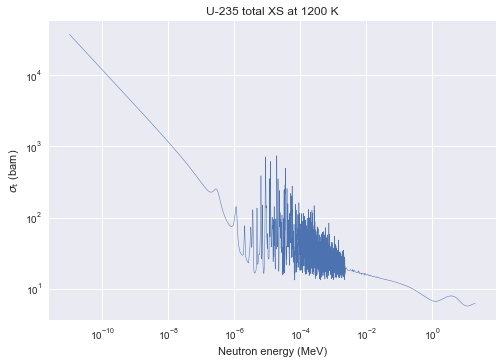

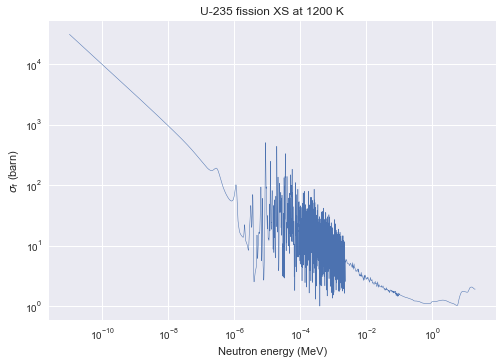

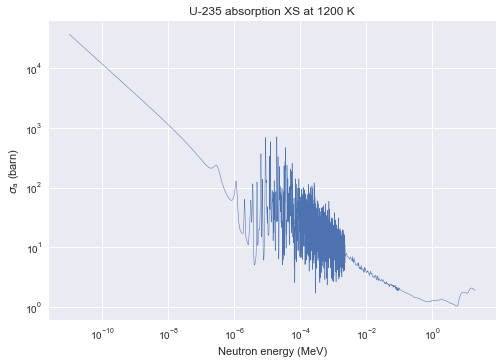

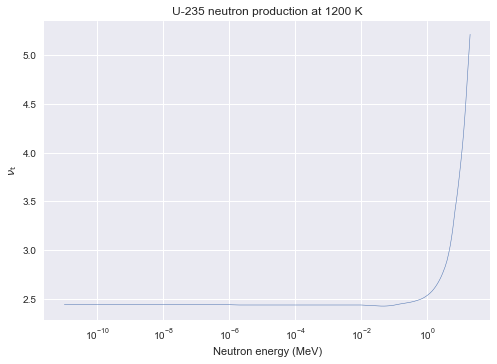

In [460]:
U235 = load_ace(92235)
U235_12 = U235.tables['92235.12c']

U238 = load_ace(92238, suffix='JF311.ace')
U238_12 = U238.tables['92238.12c']

Hydrogen

In [ ]:
lw_density = 0.9966

H1_mass = atomic_mass('1H')
print(ln_energy_decrement(H1_mass))
print(ave_collisions(H1_mass))

H1 = load_ace(1001)
H1_3 = H1.tables['1001.03c']

plot_compare_mts(H1_3, (1,2), ('total','elastic scattering'),
                 title='Hydrogen 1 total and elastic scattering XS',
                 save='H1_MT1_MT2')

(<Figure size 576x396 with 1 Axes>,
 <AxesSubplot:title={'center':'Hydrogen 1 moderating ratio at 300 K'}, xlabel='Neutron energy (MeV)', ylabel='Moderating ratio'>)

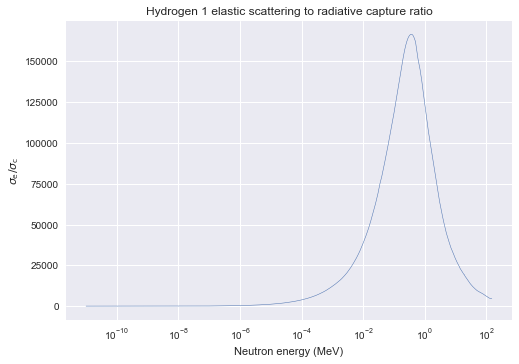

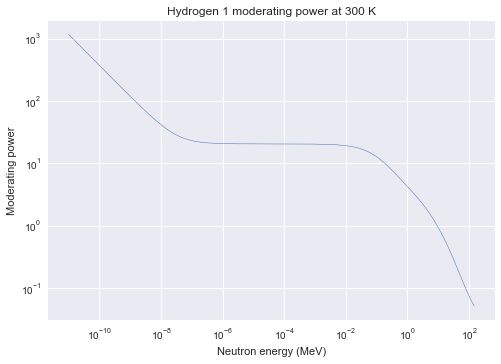

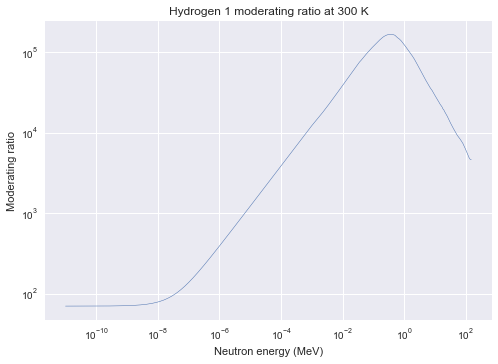

In [474]:
SCR = H1_3.reactions[2].sigma/H1_3.reactions[102].sigma

plot_ratio(H1_3.energy, SCR,
           '$ \sigma_{\mathrm{e}} / \sigma_{\mathrm{c}} $ ',
           title='Hydrogen 1 elastic scattering to radiative capture ratio',
           save='H1_SCR',
           ylim=None)

mp = moderating_power(H1_mass, H1_3)

plot_xs(H1_3.energy, mp, 'Moderating power',
        title='Hydrogen 1 moderating power at 300 K',
        save='H1_MP')

mr = moderating_ratio(H1_mass, H1_3)

plot_xs(H1_3.energy, mr, 'Moderating ratio',
        title='Hydrogen 1 moderating ratio at 300 K',
        save='H1_MR')

Oxygen

In [ ]:
O16 = load_ace(8016)
O16_3 = O16.tables['8016.03c']

plot_temperatures(O16, 2, xs_e,
                  title='Oxygen 16 elastic scattering XS',
                  save='O16_MT2')

plot_temperatures(O16, 102, xs_gamma,
                  title='Oxygen 16 capture XS',
                  save='O16_MT102')

In [ ]:
H2_mass = atomic_mass('2H')
print(ln_energy_decrement(H2_mass))
print(ave_collisions(H2_mass))